# Test to see if we can Annotate after merging 
(which makes sense) to save time for now

In [1]:
getwd()

[1] "/mnt/md0/isshamie/Projects/Mito_Trace/R_scripts/genomeCompare"

## Creates binarized Seurat objects, integrates conditions and annotates genes by nearby peaks

In [2]:
pbmc_indir <- "/mnt/md0/isshamie/Projects/Mito_Trace/output/pipeline/DUPI_april08_2021/MTblacklist_mtasnucl_Bonly/data/annotation/mergedSamples/"
pbmc_sample_names = "preB,postB"
tcell_indir = "/mnt/md0/isshamie/Projects/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/annotation/mergedSamples/"
tcell_sample_names = "pre,post"


outdir = "/mnt/md0/isshamie/Projects/Mito_Trace/output/genomeCompare/exp_mergedSamples/"

# Parameters
nTop = 25000
lsi_start_comp = 2
to.filt.cells = "TRUE"

to.qc = FALSE
## QC parameters
# min_peak_region_fragments=1000
# max_peak_region_fragments=10000
# min_pct_reads_in_peaks=20
# max_blacklist_ratio=0.05
# max_nucleosome_signal=15
# min_TSS_enrichment=0.2

min_peak_region_fragments=10
max_peak_region_fragments=15000
min_pct_reads_in_peaks=15
max_blacklist_ratio=0.05
max_nucleosome_signal=4
min_TSS_enrichment=0.2

cores = 24

gene_type="custom" #"UCSC" #or custom
gene_files = c(ucsc="UCSC",
               A2_black="/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist_A2_2020/genes/genes.gtf",
               hg38_1_2="/data/Mito_Trace/data/external/GRCh38_1.2.0/refdata-cellranger-atac-GRCh38-1.2.0/genes/genes.gtf",
               hg38_ucsc="hg38_UCSC"
              )

In [3]:
markers_f <- "/data/Mito_Trace/data/processed/pbmc_markers.txt"
markers <- read.csv(markers_f, header=F)[[1]]


In [4]:
utils_script <- "/data/Mito_Trace/R_scripts/seurat_utils.R"
source(utils_script)

Attaching SeuratObject



In [5]:
if ((to.filt.cells == "T") | (to.filt.cells == "TRUE")){
    to.filt.cells = TRUE
}else{to.filt.cells = FALSE}


In [6]:
library(repr)
options(repr.plot.width=12, repr.plot.height=12)

In [7]:
pbmc_sample_names <- unlist(strsplit(pbmc_sample_names, ","))
pbmc_sample_names

[1] "preB"  "postB"

In [8]:
tcell_sample_names <- unlist(strsplit(tcell_sample_names, ","))
tcell_sample_names

[1] "pre"  "post"

In [9]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(EnsDb.Hsapiens.v86)

library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library(dplyr)
library("patchwork")
library(future)
library(Rsamtools)


plan("multiprocess", workers = cores)
options(future.globals.maxSize = 8000 * 1024^2)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
#plan("multiprocess", workers = workers)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb

Loading required package: ensembldb

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi

Lo

In [10]:
pbmc.allSE <- readRDS(file.path(pbmc_indir, paste0("allSamples.rds")))

In [11]:
pbmc.allSE

[[1]]
An object of class Seurat 
40000 features across 1351 samples within 1 assay 
Active assay: ATAC (40000 features, 0 variable features)

[[2]]
An object of class Seurat 
41874 features across 2890 samples within 1 assay 
Active assay: ATAC (41874 features, 0 variable features)


## Filter cells if parameters there

In [12]:
filtCells <- function(se, min_peak_region_fragments=10,
                      max_peak_region_fragments=15000,
                     min_pct_reads_in_peaks=15,
                     max_blacklist_ratio=0.05,
                     max_nucleosome_signal=4,
                     min_TSS_enrichment=2){
    print('se before filt')
    print(se)
    se <- subset(
      x = se,
      subset = peak_region_fragments > min_peak_region_fragments &
               peak_region_fragments < max_peak_region_fragments &
               pct_reads_in_peaks > min_pct_reads_in_peaks &
               blacklist_ratio < max_blacklist_ratio &
               nucleosome_signal < max_nucleosome_signal  &
               TSS.enrichment > min_TSS_enrichment
    )
    print('se after filt')
    print(se)
    return(se)
}

In [13]:
if (to.filt.cells){
    pbmc.allSE <- lapply(pbmc.allSE, filtCells,
                    min_peak_region_fragments=min_peak_region_fragments,
                    max_peak_region_fragments=max_peak_region_fragments,
                    min_pct_reads_in_peaks=min_pct_reads_in_peaks,
                    max_blacklist_ratio=max_blacklist_ratio,
                    max_nucleosome_signal=max_nucleosome_signal,
                    min_TSS_enrichment=min_TSS_enrichment)
}

[1] "se before filt"
An object of class Seurat 
40000 features across 1351 samples within 1 assay 
Active assay: ATAC (40000 features, 0 variable features)
[1] "se after filt"
An object of class Seurat 
40000 features across 1311 samples within 1 assay 
Active assay: ATAC (40000 features, 0 variable features)
[1] "se before filt"
An object of class Seurat 
41874 features across 2890 samples within 1 assay 
Active assay: ATAC (41874 features, 0 variable features)
[1] "se after filt"
An object of class Seurat 
41874 features across 2794 samples within 1 assay 
Active assay: ATAC (41874 features, 0 variable features)


## Compute Gene Activity for each gene file

In [16]:
get.annotations <- function(gene_file, gene_files){
    print(gene_file)
    if (gene_file=="ucsc"){
        annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v75)
        seqlevelsStyle(annotations) <- 'UCSC'
        genome(annotations) <- "hg38"
    }else if(gene_file=="hg38_ucsc"){
        annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
        seqlevelsStyle(annotations) <- 'UCSC'
        genome(annotations) <- "hg38"        
    }else{
        gffRangedData<-rtracklayer::import.gff(gene_files[[gene_file]], format="gtf", genome="hg38")
        annotations<-as(gffRangedData, "GRanges")
        if (! "gene_biotype" %in% colnames(values(annotations)) ){
            values(annotations)$gene_biotype <- values(annotations)$gene_type
        }
    }
    return(annotations)
}

In [17]:
names(gene_files)

[1] "ucsc"      "A2_black"  "hg38_1_2"  "hg38_ucsc"

In [18]:
all.annotations <- sapply(names(gene_files), get.annotations, gene_files=gene_files)

[1] "ucsc"


Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

[1] "A2_black"


Warning message in readGFFAsGRanges(resource, version = version, colnames = colnames, :
"cannot set the seqlengths or circularity flags on the GRanges object to
  return because the sequence names in the GTF or GFF file are in
  disagreement with the sequence names implied by the genome assembly
  (hg38) specified via the 'genome' argument"


[1] "hg38_1_2"
[1] "hg38_ucsc"


Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

In [19]:
names(all.annotations)

[1] "ucsc"      "A2_black"  "hg38_1_2"  "hg38_ucsc"

In [20]:
get.gene.activity <- function(se, gene_file){
    annotations <- all.annotations[[gene_file]]
    # add the gene information to the object
    Annotation(se) <- annotations
    
    print("Gene activity score")
    gene.activities <- GeneActivity(se)
    # compute nucleosome signal score per cell    
        # add the gene activity matrix to the Seurat object as a new assay and normalize it
    curr.assay.name <- paste0("RNA_", gene_file)
    se[[curr.assay.name]] <- CreateAssayObject(counts = gene.activities)
    se <- NormalizeData(
      object = se,
      assay = curr.assay.name,
      normalization.method = 'LogNormalize',
      scale.factor = median(se[[]][, paste0("nCount_", curr.assay.name)])
    )
    return(se)
}

## Run for each sample separately

In [21]:
add.all.gene.f <- function(se){
    print(se)
    for (i in names(gene_files)){
        print(i)
        print(gene_files[[i]])
        se <- get.gene.activity(se, gene_file=i)

        }
    return(se)
    }


In [22]:
pbmc.genes.allSE <- sapply(pbmc.allSE, add.all.gene.f)

An object of class Seurat 
40000 features across 1311 samples within 1 assay 
Active assay: ATAC (40000 features, 0 variable features)
[1] "ucsc"
[1] "UCSC"
[1] "Gene activity score"


Extracting gene coordinates

Extracting reads overlapping genomic regions

Warning message:
"Non-unique features (rownames) present in the input matrix, making unique"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from rna_ucsc_ to rnaucsc_"


[1] "A2_black"
[1] "/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist_A2_2020/genes/genes.gtf"
[1] "Gene activity score"


Extracting gene coordinates

Extracting reads overlapping genomic regions

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from rna_a2_black_ to rnaa2black_"


[1] "hg38_1_2"
[1] "/data/Mito_Trace/data/external/GRCh38_1.2.0/refdata-cellranger-atac-GRCh38-1.2.0/genes/genes.gtf"
[1] "Gene activity score"


Extracting gene coordinates

Extracting reads overlapping genomic regions

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from rna_hg38_1_2_ to rnahg3812_"


[1] "hg38_ucsc"
[1] "hg38_UCSC"
[1] "Gene activity score"


Extracting gene coordinates

Extracting reads overlapping genomic regions

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from rna_hg38_ucsc_ to rnahg38ucsc_"


An object of class Seurat 
41874 features across 2794 samples within 1 assay 
Active assay: ATAC (41874 features, 0 variable features)
[1] "ucsc"
[1] "UCSC"
[1] "Gene activity score"


Extracting gene coordinates

Extracting reads overlapping genomic regions

Warning message:
"Non-unique features (rownames) present in the input matrix, making unique"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from rna_ucsc_ to rnaucsc_"


[1] "A2_black"
[1] "/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist_A2_2020/genes/genes.gtf"
[1] "Gene activity score"


Extracting gene coordinates

Extracting reads overlapping genomic regions

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from rna_a2_black_ to rnaa2black_"


[1] "hg38_1_2"
[1] "/data/Mito_Trace/data/external/GRCh38_1.2.0/refdata-cellranger-atac-GRCh38-1.2.0/genes/genes.gtf"
[1] "Gene activity score"


Extracting gene coordinates

Extracting reads overlapping genomic regions

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from rna_hg38_1_2_ to rnahg3812_"


[1] "hg38_ucsc"
[1] "hg38_UCSC"
[1] "Gene activity score"


Extracting gene coordinates

Extracting reads overlapping genomic regions

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from rna_hg38_ucsc_ to rnahg38ucsc_"


In [23]:
pbmc.genes.allSE[[1]]

An object of class Seurat 
118270 features across 1311 samples within 5 assays 
Active assay: ATAC (40000 features, 0 variable features)
 4 other assays present: RNA_ucsc, RNA_A2_black, RNA_hg38_1_2, RNA_hg38_ucsc

In [24]:
preB.pbmc.se <- pbmc.genes.allSE[[1]]

preB.pbmc.se

postB.pbmc.se <- pbmc.genes.allSE[[2]]

postB.pbmc.se


An object of class Seurat 
118270 features across 1311 samples within 5 assays 
Active assay: ATAC (40000 features, 0 variable features)
 4 other assays present: RNA_ucsc, RNA_A2_black, RNA_hg38_1_2, RNA_hg38_ucsc

An object of class Seurat 
120144 features across 2794 samples within 5 assays 
Active assay: ATAC (41874 features, 0 variable features)
 4 other assays present: RNA_ucsc, RNA_A2_black, RNA_hg38_1_2, RNA_hg38_ucsc

## Check the MT annotated peaks and genes

## Not in the granges of pbmc even though it was MTasnucl. 
(didn't i see it in gene activity?)

In [25]:
message("Unique chromosomes in postDUPI")
unique(seqnames(granges(postB.pbmc.se)))

message("chrMT peaks in postDUPI")
granges(postB.pbmc.se)[seqnames(granges(postB.pbmc.se)) == "chrMT"]

message("chrM peaks in postDUPI")
granges(postB.pbmc.se)[seqnames(granges(postB.pbmc.se)) == "chrM"]


message("Unique chromosomes in preDUPI")
granges(preB.pbmc.se)@seqnames

message("chrMT peaks in preDUPI")
granges(preB.pbmc.se)[seqnames(granges(preB.pbmc.se)) == "chrMT"]


message("chr1 peaks in preDUPI")
granges(preB.pbmc.se)[seqnames(granges(preB.pbmc.se)) == "chr1"]
message("chr2 peaks in preDUPI")
granges(preB.pbmc.se)[seqnames(granges(preB.pbmc.se)) == "chr2"]
message("chrM peaks in preDUPI")
granges(preB.pbmc.se)[seqnames(granges(preB.pbmc.se)) == "chrM"]


Unique chromosomes in postDUPI



[1] chr1  chr2  chr3  chr4  chr5  chr6  chr7  chr8  chr9  chr10 chr11 chr12
[13] chr13 chr14 chr15 chr16 chr17 chr18 chr19 chr20 chr21 chr22 chrX  chrY 
24 Levels: chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 ... chrY

chrMT peaks in postDUPI



GRanges object with 0 ranges and 0 metadata columns:
   seqnames    ranges strand
      <Rle> <IRanges>  <Rle>
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

chrM peaks in postDUPI



GRanges object with 0 ranges and 0 metadata columns:
   seqnames    ranges strand
      <Rle> <IRanges>  <Rle>
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

Unique chromosomes in preDUPI



factor-Rle of length 40000 with 24 runs
  Lengths:  3933  3121  2353  1464  1895 ...  1060   471   910  1078    18
  Values : chr1  chr2  chr3  chr4  chr5  ... chr20 chr21 chr22 chrX  chrY 
Levels(24): chr1 chr2 chr3 chr4 chr5 chr6 ... chr19 chr20 chr21 chr22 chrX chrY

chrMT peaks in preDUPI



GRanges object with 0 ranges and 0 metadata columns:
   seqnames    ranges strand
      <Rle> <IRanges>  <Rle>
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

chr1 peaks in preDUPI



GRanges object with 3933 ranges and 0 metadata columns:
         seqnames              ranges strand
            <Rle>           <IRanges>  <Rle>
     [1]     chr1       268046-268142      *
     [2]     chr1       778355-779233      *
     [3]     chr1       827080-827940      *
     [4]     chr1       844530-844785      *
     [5]     chr1       865681-865926      *
     ...      ...                 ...    ...
  [3929]     chr1 248858094-248859625      *
  [3930]     chr1 248862858-248863683      *
  [3931]     chr1 248872949-248874682      *
  [3932]     chr1 248905881-248907165      *
  [3933]     chr1 248924667-248925484      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

chr2 peaks in preDUPI



GRanges object with 3121 ranges and 0 metadata columns:
         seqnames              ranges strand
            <Rle>           <IRanges>  <Rle>
     [1]     chr2         11506-11785      *
     [2]     chr2         46465-46834      *
     [3]     chr2       176168-176841      *
     [4]     chr2       193010-193523      *
     [5]     chr2       263685-265421      *
     ...      ...                 ...    ...
  [3117]     chr2 241965968-241966462      *
  [3118]     chr2 241984990-241985649      *
  [3119]     chr2 242031494-242032221      *
  [3120]     chr2 242085588-242086451      *
  [3121]     chr2 242088317-242089034      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

chrM peaks in preDUPI



GRanges object with 0 ranges and 0 metadata columns:
   seqnames    ranges strand
      <Rle> <IRanges>  <Rle>
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

## Plot dimplot before removing MT peaks

In [26]:
pbmc.embed.genes.allSE <- lapply(pbmc.genes.allSE, embed.atac, return.depth=F)

Performing TF-IDF normalization

Running SVD

Scaling cell embeddings

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
13:33:23 UMAP embedding parameters a = 0.9922 b = 1.112

13:33:23 Read 1311 rows and found 49 numeric columns

13:33:23 Using Annoy for neighbor search, n_neighbors = 30

13:33:23 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:33:23 Writing NN index file to temp file /tmp/Rtmps9ImcG/file22f5921401eb82

13:33:23 Searching Annoy index using 24 threads, search_k = 3000

13:33:23 Annoy recall = 100%

13:33:25 Commencin

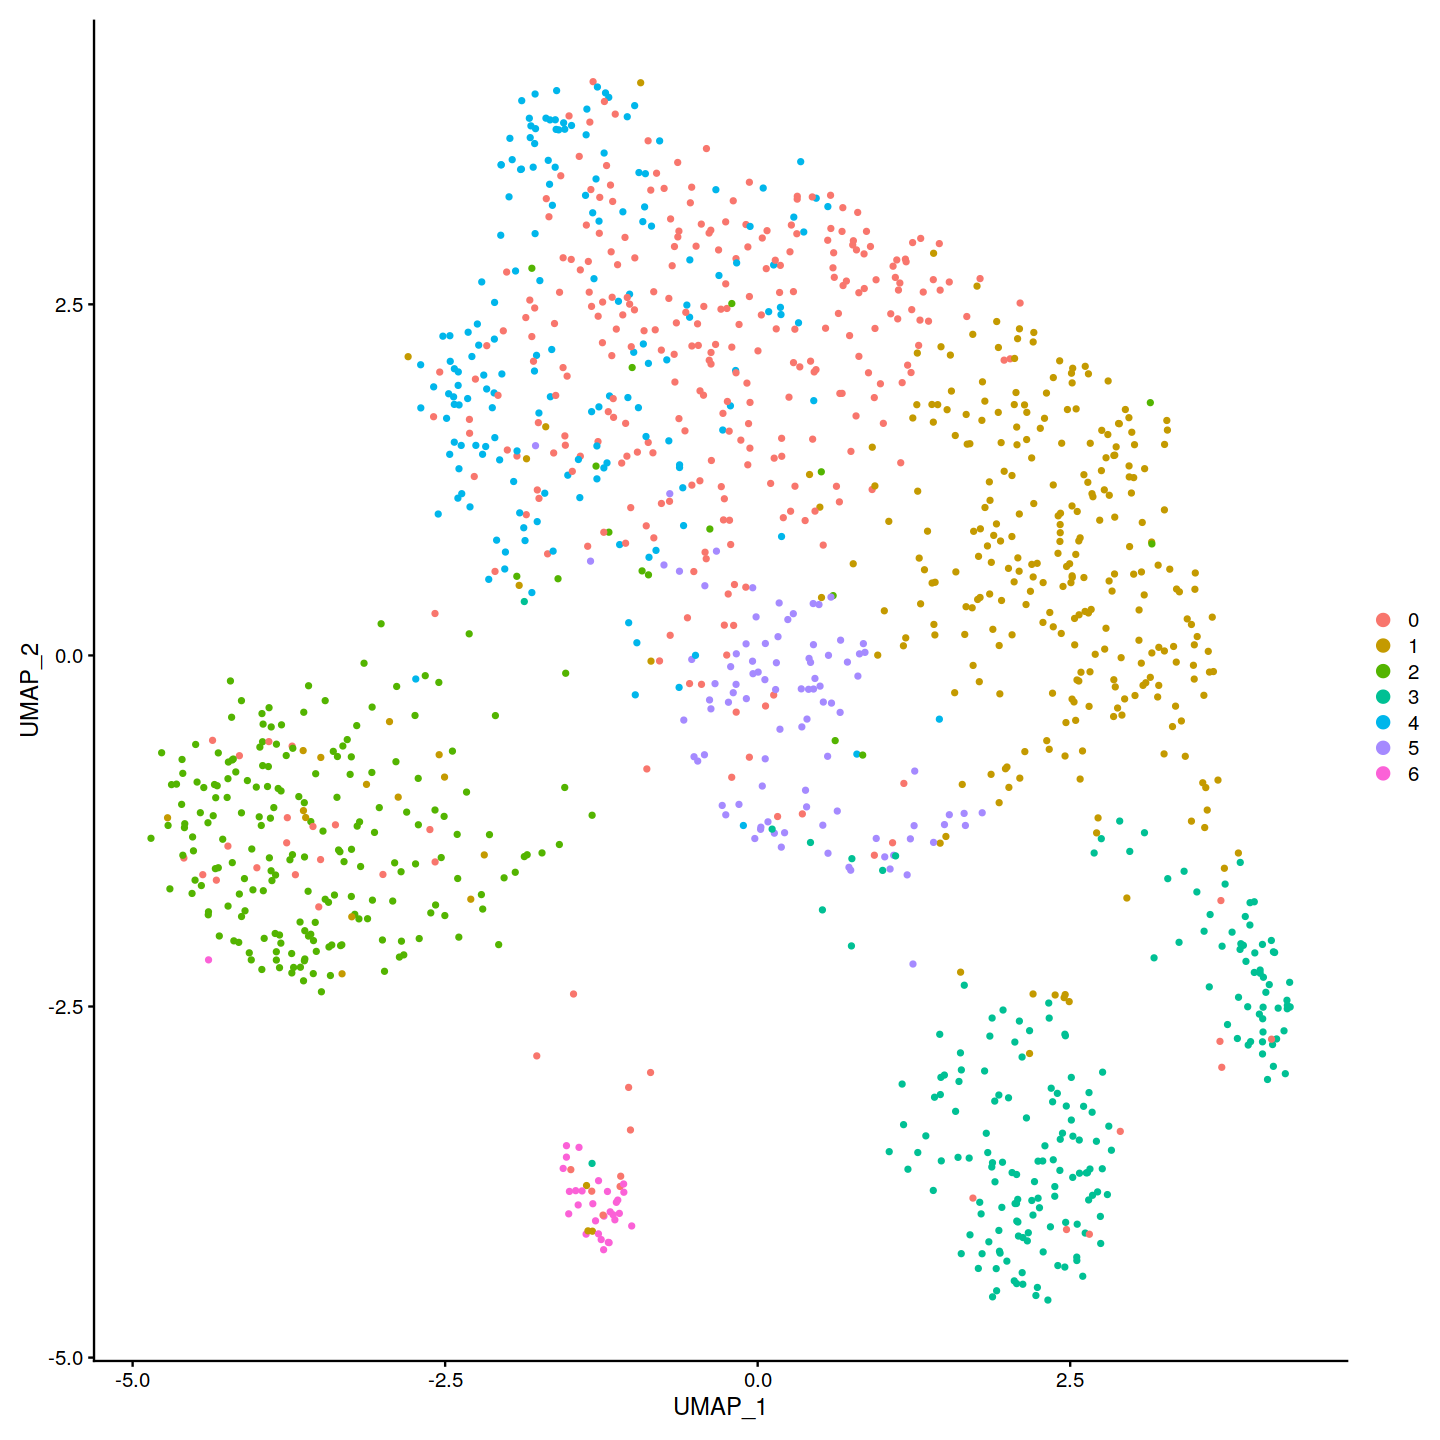

In [27]:
DimPlot(pbmc.embed.genes.allSE[[1]])

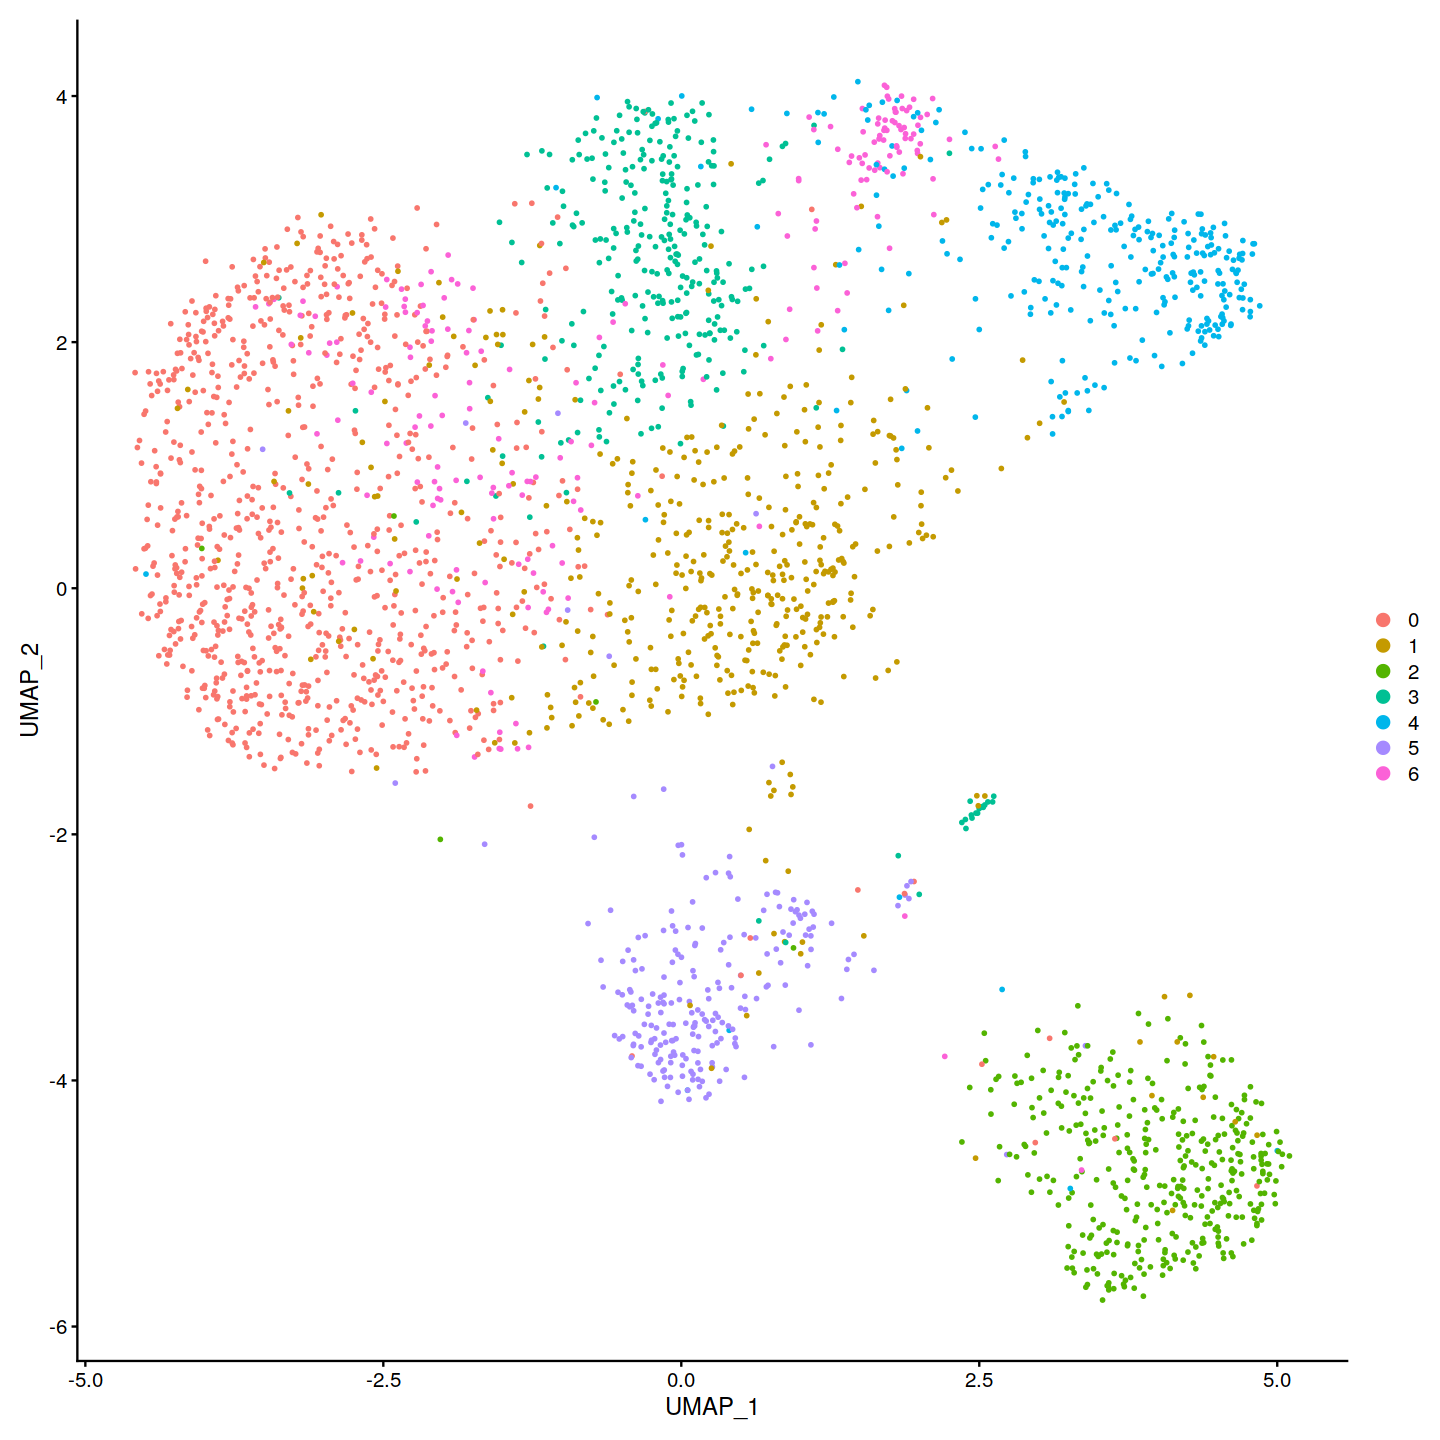

In [28]:
DimPlot(pbmc.embed.genes.allSE[[2]])

## Remove MT peaks and plot dimplot

### There are none, so no need

## Create immune markers embeddings on the dimplots for each genome file

In [29]:
#Annotation(pbmc.embed.genes.allSE[[1]], value=all.annotations["A2_black"])

## Look at closest features  using different annotation

In [30]:
ClosestFeature(pbmc.embed.genes.allSE[[2]], head(rownames(pbmc.embed.genes.allSE[[2]]),10), 
               annotation=all.annotations[[1]])

ClosestFeature(pbmc.embed.genes.allSE[[2]], head(rownames(pbmc.embed.genes.allSE[[2]]),10),
               annotation=all.annotations[[2]])

ClosestFeature(pbmc.embed.genes.allSE[[2]], head(rownames(pbmc.embed.genes.allSE[[2]]),10),
               annotation=all.annotations[[3]])

,tx_id,gene_name,gene_id,gene_biotype,type,closest_region,query_region,distance
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<int>
ENSE00001947154,ENST00000466557,RP11-34P13.13,ENSG00000241860,processed_transcript,exon,chr1-173753-173862,chr1-191337-191519,17474
ENSE00001697423,ENST00000424587,AP006222.2,ENSG00000228463,lincRNA,exon,chr1-267096-267253,chr1-268046-268142,792
ENST00000610067,ENST00000610067,LINC01128,ENSG00000228794,processed_transcript,gap,chr1-764485-783033,chr1-778355-779233,0
ENST00000594233,ENST00000594233,AL645608.2,ENSG00000269308,protein_coding,cds,chr1-819961-819983,chr1-827080-827940,7096
ENST00000607769,ENST00000607769,RP11-54O7.16,ENSG00000272438,lincRNA,gap,chr1-840338-851129,chr1-844530-844785,0
ENST00000598827,ENST00000598827,AL645608.1,ENSG00000268179,protein_coding,cds,chr1-865666-865719,chr1-865681-865926,0
ENST00000437963,ENST00000437963,SAMD11,ENSG00000187634,protein_coding,gap,chr1-866470-871151,chr1-869653-870170,0
ENST00000379410,ENST00000379410,PLEKHN1,ENSG00000187583,protein_coding,gap,chr1-902184-905656,chr1-904417-905473,0
ENST00000379410.1,ENST00000379410,PLEKHN1,ENSG00000187583,protein_coding,cds,chr1-906704-906784,chr1-906758-907079,0


source,type,score,phase,gene_id,gene_version,gene_type,gene_name,level,hgnc_id,⋯,exon_number,exon_id,exon_version,protein_id,ccdsid,ont,gene_biotype,closest_region,query_region,distance
<fct>,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
HAVANA,gene,NA,NA,ENSG00000241860,7,lncRNA,AL627309.5,2,NA,⋯,NA,NA,NA,NA,NA,NA,lncRNA,chr1-141474-173862,chr1-191337-191519,17474
HAVANA,exon,NA,NA,ENSG00000286448,1,lncRNA,AP006222.2,2,NA,⋯,2,ENSE00003852409,1,NA,NA,NA,lncRNA,chr1-268122-268655,chr1-268046-268142,0
HAVANA,exon,NA,NA,ENSG00000237491,10,lncRNA,LINC01409,2,HGNC:50701,⋯,1,ENSE00001610263,2,NA,NA,NA,lncRNA,chr1-778972-779092,chr1-778355-779233,0
HAVANA,exon,NA,NA,ENSG00000225880,5,lncRNA,LINC00115,2,HGNC:26211,⋯,1,ENSE00001890287,1,NA,NA,NA,lncRNA,chr1-826206-827522,chr1-827080-827940,0
HAVANA,transcript,NA,NA,ENSG00000228794,9,lncRNA,LINC01128,2,HGNC:49377,⋯,NA,NA,NA,NA,NA,NA,lncRNA,chr1-827821-852515,chr1-844530-844785,0
HAVANA,transcript,NA,NA,ENSG00000228794,9,lncRNA,LINC01128,2,HGNC:49377,⋯,NA,NA,NA,NA,NA,NA,lncRNA,chr1-860227-868202,chr1-865681-865926,0
HAVANA,transcript,NA,NA,ENSG00000230368,2,lncRNA,FAM41C,2,HGNC:27635,⋯,NA,NA,NA,NA,NA,NA,lncRNA,chr1-868403-876802,chr1-869653-870170,0
HAVANA,exon,NA,NA,ENSG00000272438,1,lncRNA,AL645608.6,2,NA,⋯,1,ENSE00003700027,1,NA,NA,NA,lncRNA,chr1-904834-904957,chr1-904417-905473,0
HAVANA,transcript,NA,NA,ENSG00000272438,1,lncRNA,AL645608.6,2,NA,⋯,NA,NA,NA,NA,NA,NA,lncRNA,chr1-904834-915976,chr1-906758-907079,0


source,type,score,phase,gene_id,gene_type,gene_name,level,havana_gene,transcript_id,⋯,havana_transcript,exon_number,exon_id,ont,protein_id,ccdsid,gene_biotype,closest_region,query_region,distance
<fct>,<fct>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
HAVANA,transcript,NA,NA,ENSG00000279457.4,unprocessed_pseudogene,RP11-34P13.18,2,OTTHUMG00000191963.1,ENST00000623083.4,⋯,OTTHUMT00000491421.1,NA,NA,PGO:0000005,NA,NA,unprocessed_pseudogene,chr1-185217-195411,chr1-191337-191519,0
HAVANA,transcript,NA,NA,ENSG00000228463.10,transcribed_processed_pseudogene,AP006222.1,2,OTTHUMG00000002552.2,ENST00000441866.2,⋯,OTTHUMT00000346905.2,NA,NA,NA,NA,NA,transcribed_processed_pseudogene,chr1-258144-359681,chr1-268046-268142,0
HAVANA,exon,NA,NA,ENSG00000237491.8,lincRNA,RP11-206L10.9,2,OTTHUMG00000002404.7,ENST00000429505.5,⋯,OTTHUMT00000006885.2,1,ENSE00001610263.1,NA,NA,NA,lincRNA,chr1-779056-779092,chr1-778355-779233,0
HAVANA,exon,NA,NA,ENSG00000225880.5,lincRNA,NCRNA00115,2,OTTHUMG00000141258.2,ENST00000473798.1,⋯,OTTHUMT00000280398.2,1,ENSE00001890287.1,NA,NA,NA,lincRNA,chr1-826206-827522,chr1-827080-827940,0
HAVANA,transcript,NA,NA,ENSG00000228794.8,processed_transcript,RP11-206L10.11,2,OTTHUMG00000002468.7,ENST00000449005.5,⋯,OTTHUMT00000007018.2,NA,NA,NA,NA,NA,processed_transcript,chr1-827673-853626,chr1-844530-844785,0
HAVANA,exon,NA,NA,ENSG00000230368.2,lincRNA,FAM41C,2,OTTHUMG00000002469.1,ENST00000446136.1,⋯,OTTHUMT00000007021.1,3,ENSE00001645595.1,NA,NA,NA,lincRNA,chr1-868071-868675,chr1-865681-865926,2144
HAVANA,exon,NA,NA,ENSG00000230368.2,lincRNA,FAM41C,2,OTTHUMG00000002469.1,ENST00000432963.1,⋯,OTTHUMT00000007023.1,1,ENSE00001791782.1,NA,NA,NA,lincRNA,chr1-870086-870201,chr1-869653-870170,0
HAVANA,exon,NA,NA,ENSG00000272438.1,lincRNA,RP11-54O7.16,2,OTTHUMG00000185550.1,ENST00000607769.1,⋯,OTTHUMT00000470696.1,1,ENSE00003700027.1,NA,NA,NA,lincRNA,chr1-904834-904957,chr1-904417-905473,0
HAVANA,transcript,NA,NA,ENSG00000272438.1,lincRNA,RP11-54O7.16,2,OTTHUMG00000185550.1,ENST00000607769.1,⋯,OTTHUMT00000470696.1,NA,NA,NA,NA,NA,lincRNA,chr1-904834-915976,chr1-906758-907079,0


## Marker plots

In [56]:
marker.plots <- function(curr.se, curr.outdir, gene.assay){
    DefaultAssay(curr.se) <- "ATAC"
    Annotation(curr.se) <- all.annotations[[gene.assay]]
    feature.names <- ClosestFeature(curr.se, rownames(curr.se), annotation = all.annotations[[gene.assay]])
    marker.feature.names <- feature.names %>% filter(gene_name %in% markers)
    rownames(marker.feature.names) <- marker.feature.names[,"query_region"]
    # marker.feature.names
    marker.feature.names$name <- paste0(marker.feature.names$gene_name, "_", marker.feature.names$type)
    sapply(rownames(marker.feature.names), 
            FUN=featplot, se=curr.se, curr.outdir=curr.outdir, feat.names=marker.feature.names["name"])


    DefaultAssay(curr.se) <- paste0("RNA_", gene.assay) #"RNA"
    sapply(markers, 
        FUN=featplot, se=curr.se, curr.outdir=curr.outdir, feat.names=NULL)
}

In [57]:
dir.create(outdir)
pbmc.outdir <- file.path(outdir, "pbmc")
dir.create(pbmc.outdir)
for (i in names(all.annotations)){
    print(i)
    for (j in pbmc.embed.genes.allSE){
        print(j)
        curr.outdir <- file.path(pbmc.outdir, paste0(j$orig.ident[[1]], "_", i))
        dir.create(curr.outdir)
        marker.plots(j, curr.outdir, i)
    }
}

Warning message in dir.create(outdir):
"'/mnt/md0/isshamie/Projects/Mito_Trace/output/genomeCompare/exp_mergedSamples' already exists"
Warning message in dir.create(pbmc.outdir):
"'/mnt/md0/isshamie/Projects/Mito_Trace/output/genomeCompare/exp_mergedSamples//pbmc' already exists"


[1] "ucsc"
An object of class Seurat 
118270 features across 1311 samples within 5 assays 
Active assay: ATAC (40000 features, 32381 variable features)
 4 other assays present: RNA_ucsc, RNA_A2_black, RNA_hg38_1_2, RNA_hg38_ucsc
 2 dimensional reductions calculated: lsi, umap


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Feature no in object: TCRA"
[1] "Feature no in object: CD56"
[1] "Feature no in object: CD161"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Feature no in object: IGHM"
[1] "Feature no in object: TCRA"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



An object of class Seurat 
120144 features across 2794 samples within 5 assays 
Active assay: ATAC (41874 features, 37545 variable features)
 4 other assays present: RNA_ucsc, RNA_A2_black, RNA_hg38_1_2, RNA_hg38_ucsc
 2 dimensional reductions calculated: lsi, umap


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Feature no in object: TCRA"
[1] "Feature no in object: CD56"
[1] "Feature no in object: CD161"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Feature no in object: IGHM"
[1] "Feature no in object: TCRA"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "A2_black"
An object of class Seurat 
118270 features across 1311 samples within 5 assays 
Active assay: ATAC (40000 features, 32381 variable features)
 4 other assays present: RNA_ucsc, RNA_A2_black, RNA_hg38_1_2, RNA_hg38_ucsc
 2 dimensional reductions calculated: lsi, umap


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Feature no in object: TCRA"
[1] "Feature no in object: CD56"
[1] "Feature no in object: CD161"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Feature no in object: IGHM"
[1] "Feature no in object: TCRA"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



An object of class Seurat 
120144 features across 2794 samples within 5 assays 
Active assay: ATAC (41874 features, 37545 variable features)
 4 other assays present: RNA_ucsc, RNA_A2_black, RNA_hg38_1_2, RNA_hg38_ucsc
 2 dimensional reductions calculated: lsi, umap


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 

[1] "Feature no in object: TCRA"
[1] "Feature no in object: CD56"
[1] "Feature no in object: CD161"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Feature no in object: IGHM"
[1] "Feature no in object: TCRA"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "hg38_1_2"
An object of class Seurat 
118270 features across 1311 samples within 5 assays 
Active assay: ATAC (40000 features, 32381 variable features)
 4 other assays present: RNA_ucsc, RNA_A2_black, RNA_hg38_1_2, RNA_hg38_ucsc
 2 dimensional reductions calculated: lsi, umap


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Feature no in object: TCRA"
[1] "Feature no in object: CD56"
[1] "Feature no in object: CD161"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Feature no in object: IGHM"
[1] "Feature no in object: TCRA"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



An object of class Seurat 
120144 features across 2794 samples within 5 assays 
Active assay: ATAC (41874 features, 37545 variable features)
 4 other assays present: RNA_ucsc, RNA_A2_black, RNA_hg38_1_2, RNA_hg38_ucsc
 2 dimensional reductions calculated: lsi, umap


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Feature no in object: TCRA"
[1] "Feature no in object: CD56"
[1] "Feature no in object: CD161"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Feature no in object: IGHM"
[1] "Feature no in object: TCRA"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "hg38_ucsc"
An object of class Seurat 
118270 features across 1311 samples within 5 assays 
Active assay: ATAC (40000 features, 32381 variable features)
 4 other assays present: RNA_ucsc, RNA_A2_black, RNA_hg38_1_2, RNA_hg38_ucsc
 2 dimensional reductions calculated: lsi, umap


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 

[1] "Feature no in object: TCRA"
[1] "Feature no in object: CD56"
[1] "Feature no in object: CD161"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Feature no in object: IGHM"
[1] "Feature no in object: TCRA"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



An object of class Seurat 
120144 features across 2794 samples within 5 assays 
Active assay: ATAC (41874 features, 37545 variable features)
 4 other assays present: RNA_ucsc, RNA_A2_black, RNA_hg38_1_2, RNA_hg38_ucsc
 2 dimensional reductions calculated: lsi, umap


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 

[1] "Feature no in object: TCRA"
[1] "Feature no in object: CD56"
[1] "Feature no in object: CD161"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "Feature no in object: IGHM"
[1] "Feature no in object: TCRA"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



In [33]:
#sapply(marker.plots, curr.outdir, gene.assay)

## Coverage tracks using cluster pseudobulk

In [ ]:
#library(doParallel)  # will load parallel, foreach, and iterators


# message("Cluster creation")
# cl <- makeCluster(detectCores())


# registerDoParallel(cl)

In [71]:
for (j in pbmc.embed.genes.allSE){
    print(j)
    #foreach(i = 1:length(names(all.annotations))) %dopar%{
    for (gene.assay in c("hg38_1_2", "ucsc", "A2_black", "hg38_ucsc")){
    #for (gene.assay in (names(all.annotations))){
        #gene.assay = names(all.annotations)[[i]]
        message(gene.assay)
        curr.outdir <- file.path(pbmc.outdir, paste0(j$orig.ident[[1]], "_", gene.assay), "coverage")
        dir.create(curr.outdir)
        #marker.plots(j, curr.outdir, i)
        
        Annotation(j) <- all.annotations[[gene.assay]]
        feature.names <- ClosestFeature(j, rownames(j), annotation = all.annotations[[gene.assay]])

        marker.feature.names <- feature.names %>% filter(gene_name %in% markers)
        rownames(marker.feature.names) <- marker.feature.names[,"query_region"]
        # marker.feature.names
        marker.feature.names$name <- paste0(marker.feature.names$gene_name, "_", marker.feature.names$type)
        
        # get unique marker feature names to not get too many redundant ones
        marker.feature.names[!duplicated(marker.feature.names$gene_name),]
        
        for (m in rownames(marker.feature.names)){
            print(m)
           # tryCatch({  
                CoveragePlot(
                             object = j,
                             region = m,
                             extend.upstream = 40000,
                             extend.downstream = 20000
                )
           # },
            #error=function(cond){
                #message("Region out of bounds. Not doing any extension")
               # CoveragePlot(object = j, region = m)
           # })
            ggsave(file.path(curr.outdir, paste0(marker.feature.names[m,"name"],".",m, ".coverage.plot.png")))
         }
    }
    #stopCluster(cl)

}

An object of class Seurat 
118270 features across 1311 samples within 5 assays 
Active assay: ATAC (40000 features, 32381 variable features)
 4 other assays present: RNA_ucsc, RNA_A2_black, RNA_hg38_1_2, RNA_hg38_ucsc
 2 dimensional reductions calculated: lsi, umap


hg38_1_2



[1] "chr1-153544897-153546150"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr1-161541921-161542393"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr2-85679127-85679598"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 47 rows containing missing values (geom_segment)."


[1] "chr2-85694045-85694478"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."


[1] "chr2-85704887-85705355"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 15 rows containing missing values (geom_segment)."


[1] "chr2-85706547-85707737"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 21 rows containing missing values (geom_segment)."


[1] "chr2-86784055-86784426"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr2-86785367-86786744"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."
Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr2-86790714-86791773"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr2-86793711-86794143"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr2-86807433-86808971"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 35 rows containing missing values (geom_segment)."


[1] "chr5-35852400-35852876"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 146 rows containing missing values (geom_segment)."


[1] "chr5-35853491-35855028"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 143 rows containing missing values (geom_segment)."


[1] "chr5-35856179-35857318"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr5-35857832-35858112"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr5-35858879-35859737"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 3 rows containing missing values (geom_segment)."


[1] "chr5-140632021-140633543"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 42 rows containing missing values (geom_segment)."


[1] "chr5-140634986-140635405"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 22 rows containing missing values (geom_segment)."


[1] "chr11-60455342-60456049"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 18 rows containing missing values (geom_segment)."


[1] "chr11-60457647-60457938"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 23 rows containing missing values (geom_segment)."


[1] "chr11-60477019-60477591"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 15 rows containing missing values (geom_segment)."


[1] "chr17-40540446-40541970"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 13 rows containing missing values (geom_segment)."


[1] "chr17-40547327-40547903"


Saving 6.67 x 6.67 in image



[1] "chr17-40553754-40554013"


Saving 6.67 x 6.67 in image



[1] "chr17-40560193-40562417"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr17-40564089-40565964"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 3 rows containing missing values (geom_segment)."


[1] "chr17-40577692-40578039"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (geom_segment)."
Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr19-51372552-51373202"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr19-54905801-54906221"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 59 rows containing missing values (geom_segment)."
ucsc

Warning message in dir.create(curr.outdir):
"'/mnt/md0/isshamie/Projects/Mito_Trace/output/genomeCompare/exp_mergedSamples//pbmc/preB_ucsc/coverage' already exists"


[1] "chr1-161523797-161524588"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 47 rows containing missing values (geom_segment)."


[1] "chr1-161529790-161531534"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 118 rows containing missing values (geom_segment)."
Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr1-161539721-161540821"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 60 rows containing missing values (geom_segment)."


[1] "chr1-161541921-161542393"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 60 rows containing missing values (geom_segment)."


[1] "chr1-161555025-161555205"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 70 rows containing missing values (geom_segment)."


[1] "chr1-161561347-161561621"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 96 rows containing missing values (geom_segment)."


[1] "chr1-161566382-161566527"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 96 rows containing missing values (geom_segment)."


[1] "chr5-35852400-35852876"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 201 rows containing missing values (geom_segment)."


[1] "chr5-35853491-35855028"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 194 rows containing missing values (geom_segment)."


[1] "chr5-35856179-35857318"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr5-35857832-35858112"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr5-35858879-35859737"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."


[1] "chr12-69738349-69740110"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 10 rows containing missing values (geom_segment)."


[1] "chr17-38700799-38702992"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 6 rows containing missing values (position_stack)."


[1] "chr17-38703704-38705612"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."


[1] "chr17-38706973-38707066"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 3 rows containing missing values (position_stack)."


[1] "chr17-38718654-38718906"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr17-38727664-38728934"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 3 rows containing missing values (position_stack)."


[1] "chr17-38729886-38730583"


Saving 6.67 x 6.67 in image



[1] "chr20-23606564-23606975"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."
A2_black



[1] "chr1-153544897-153546150"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr1-161539721-161540821"


Saving 6.67 x 6.67 in image



[1] "chr1-161541921-161542393"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."


[1] "chr2-85679127-85679598"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."
Warning message:
"Removed 98 rows containing missing values (geom_segment)."


[1] "chr2-85694045-85694478"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."


[1] "chr2-85704887-85705355"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 29 rows containing missing values (geom_segment)."


[1] "chr2-85706547-85707737"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 40 rows containing missing values (geom_segment)."


[1] "chr2-86784055-86784426"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr2-86785367-86786744"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr2-86790714-86791773"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 3 rows containing missing values (geom_segment)."


[1] "chr2-86793711-86794143"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 7 rows containing missing values (geom_segment)."


[1] "chr2-86807433-86808971"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 40 rows containing missing values (geom_segment)."


[1] "chr5-35852400-35852876"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 239 rows containing missing values (geom_segment)."


[1] "chr5-35853491-35855028"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 233 rows containing missing values (geom_segment)."


[1] "chr5-35856179-35857318"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr5-35857832-35858112"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr5-35858879-35859737"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 3 rows containing missing values (geom_segment)."


[1] "chr5-140612037-140612411"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 4 rows containing missing values (position_stack)."
Warning message:
"Removed 14 rows containing missing values (geom_segment)."
Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr5-140632021-140633543"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 40 rows containing missing values (geom_segment)."


[1] "chr5-140634986-140635405"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 31 rows containing missing values (geom_segment)."


[1] "chr11-60455342-60456049"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 43 rows containing missing values (geom_segment)."


[1] "chr11-60457647-60457938"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 51 rows containing missing values (geom_segment)."


[1] "chr11-60477019-60477591"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 40 rows containing missing values (geom_segment)."


[1] "chr14-105857396-105858608"


Saving 6.67 x 6.67 in image



[1] "chr17-40540446-40541970"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 23 rows containing missing values (geom_segment)."


[1] "chr17-40547327-40547903"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."


[1] "chr17-40553754-40554013"


Saving 6.67 x 6.67 in image



[1] "chr17-40560193-40562417"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr17-40564089-40565964"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 6 rows containing missing values (geom_segment)."


[1] "chr17-40577692-40578039"


Saving 6.67 x 6.67 in image



[1] "chr17-40582222-40582846"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."


[1] "chr17-40586287-40586688"


Saving 6.67 x 6.67 in image



[1] "chr19-51372552-51373202"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr19-54905801-54906221"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 79 rows containing missing values (geom_segment)."
hg38_ucsc



[1] "chr1-153544897-153546150"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr1-161541921-161542393"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr2-85679127-85679598"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 98 rows containing missing values (geom_segment)."


[1] "chr2-85694045-85694478"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."


[1] "chr2-85704887-85705355"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 5 rows containing missing values (position_stack)."
Warning message:
"Removed 25 rows containing missing values (geom_segment)."


[1] "chr2-85706547-85707737"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 34 rows containing missing values (geom_segment)."


[1] "chr2-86784055-86784426"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr2-86785367-86786744"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr2-86790714-86791773"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 3 rows containing missing values (geom_segment)."


[1] "chr2-86793711-86794143"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 7 rows containing missing values (geom_segment)."


[1] "chr2-86807433-86808971"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 40 rows containing missing values (geom_segment)."


[1] "chr5-35852400-35852876"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 236 rows containing missing values (geom_segment)."


[1] "chr5-35853491-35855028"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 230 rows containing missing values (geom_segment)."


[1] "chr5-35856179-35857318"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr5-35857832-35858112"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr5-35858879-35859737"


Saving 6.67 x 6.67 in image



[1] "chr5-140612037-140612411"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 6 rows containing missing values (position_stack)."
Warning message:
"Removed 22 rows containing missing values (geom_segment)."
Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr5-140632021-140633543"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 51 rows containing missing values (geom_segment)."


[1] "chr5-140634986-140635405"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 31 rows containing missing values (geom_segment)."


[1] "chr11-60377699-60378798"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."
Warning message:
"Removed 34 rows containing missing values (geom_segment)."


[1] "chr11-60389478-60389879"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."
Warning message:
"Removed 20 rows containing missing values (geom_segment)."


[1] "chr11-60455342-60456049"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 43 rows containing missing values (geom_segment)."


[1] "chr11-60457647-60457938"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 51 rows containing missing values (geom_segment)."


[1] "chr11-60477019-60477591"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 40 rows containing missing values (geom_segment)."


[1] "chr11-113289585-113289735"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 224 rows containing missing values (geom_segment)."


[1] "chr17-40540446-40541970"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 23 rows containing missing values (geom_segment)."


[1] "chr17-40547327-40547903"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."


[1] "chr17-40553754-40554013"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."


[1] "chr17-40560193-40562417"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr17-40564089-40565964"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 3 rows containing missing values (geom_segment)."


[1] "chr17-40577692-40578039"


Saving 6.67 x 6.67 in image



[1] "chr17-40582222-40582846"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."


[1] "chr17-40586287-40586688"


Saving 6.67 x 6.67 in image



[1] "chr19-51372552-51373202"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr19-54905801-54906221"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 110 rows containing missing values (geom_segment)."


An object of class Seurat 
120144 features across 2794 samples within 5 assays 
Active assay: ATAC (41874 features, 37545 variable features)
 4 other assays present: RNA_ucsc, RNA_A2_black, RNA_hg38_1_2, RNA_hg38_ucsc
 2 dimensional reductions calculated: lsi, umap


hg38_1_2



[1] "chr1-153544897-153546150"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr1-161541921-161542393"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr2-85679127-85679598"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 47 rows containing missing values (geom_segment)."


[1] "chr2-85694045-85694478"


Saving 6.67 x 6.67 in image



[1] "chr2-85704887-85705355"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 15 rows containing missing values (geom_segment)."


[1] "chr2-85706547-85707737"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 21 rows containing missing values (geom_segment)."


[1] "chr2-86784055-86784426"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."
Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr2-86785367-86786744"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr2-86790714-86791773"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr2-86793711-86794143"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."
Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr2-86807433-86808971"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 35 rows containing missing values (geom_segment)."


[1] "chr5-35852400-35852876"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 146 rows containing missing values (geom_segment)."


[1] "chr5-35853491-35855028"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 143 rows containing missing values (geom_segment)."


[1] "chr5-35856179-35857318"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr5-35857832-35858112"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr5-35858879-35859737"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 3 rows containing missing values (geom_segment)."


[1] "chr5-140632021-140633543"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 42 rows containing missing values (geom_segment)."


[1] "chr5-140634986-140635405"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 22 rows containing missing values (geom_segment)."


[1] "chr11-60455342-60456049"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."
Warning message:
"Removed 18 rows containing missing values (geom_segment)."


[1] "chr11-60457647-60457938"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 23 rows containing missing values (geom_segment)."


[1] "chr11-60477019-60477591"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 15 rows containing missing values (geom_segment)."


[1] "chr11-113204488-113204566"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 120 rows containing missing values (geom_segment)."


[1] "chr12-69348280-69348511"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 6 rows containing missing values (geom_segment)."


[1] "chr17-40540446-40541970"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 13 rows containing missing values (geom_segment)."


[1] "chr17-40547327-40547903"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."


[1] "chr17-40553754-40554013"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."


[1] "chr17-40560193-40562417"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."
Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr17-40564089-40565964"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 3 rows containing missing values (geom_segment)."


[1] "chr17-40577692-40578039"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 1 rows containing missing values (geom_segment)."
Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr19-51372552-51373202"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr19-54905801-54906221"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 59 rows containing missing values (geom_segment)."
ucsc



[1] "chr1-161523797-161524588"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 47 rows containing missing values (geom_segment)."


[1] "chr1-161529790-161531534"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 118 rows containing missing values (geom_segment)."
Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr1-161539721-161540821"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 60 rows containing missing values (geom_segment)."


[1] "chr1-161541921-161542393"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 60 rows containing missing values (geom_segment)."


[1] "chr1-161555025-161555205"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 70 rows containing missing values (geom_segment)."


[1] "chr1-161561347-161561621"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."
Warning message:
"Removed 96 rows containing missing values (geom_segment)."


[1] "chr1-161566382-161566527"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 96 rows containing missing values (geom_segment)."


[1] "chr5-35852400-35852876"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 201 rows containing missing values (geom_segment)."


[1] "chr5-35853491-35855028"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 194 rows containing missing values (geom_segment)."


[1] "chr5-35856179-35857318"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr5-35857832-35858112"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr5-35858879-35859737"


Saving 6.67 x 6.67 in image



[1] "chr12-69738349-69740110"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 10 rows containing missing values (geom_segment)."


[1] "chr17-38700799-38702992"


Saving 6.67 x 6.67 in image



[1] "chr17-38703704-38705612"


Saving 6.67 x 6.67 in image



[1] "chr17-38706973-38707066"


Saving 6.67 x 6.67 in image



[1] "chr17-38718654-38718906"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr17-38727664-38728934"


Saving 6.67 x 6.67 in image



[1] "chr17-38729886-38730583"


Saving 6.67 x 6.67 in image



[1] "chr20-23606564-23606975"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."
A2_black



[1] "chr1-153544897-153546150"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr1-161539721-161540821"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."


[1] "chr1-161541921-161542393"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."


[1] "chr2-85679127-85679598"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 98 rows containing missing values (geom_segment)."


[1] "chr2-85694045-85694478"


Saving 6.67 x 6.67 in image



[1] "chr2-85704887-85705355"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 29 rows containing missing values (geom_segment)."


[1] "chr2-85706547-85707737"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 40 rows containing missing values (geom_segment)."


[1] "chr2-86784055-86784426"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr2-86785367-86786744"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr2-86790714-86791773"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 3 rows containing missing values (geom_segment)."


[1] "chr2-86793711-86794143"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 7 rows containing missing values (geom_segment)."


[1] "chr2-86807433-86808971"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 40 rows containing missing values (geom_segment)."


[1] "chr5-35852400-35852876"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 239 rows containing missing values (geom_segment)."


[1] "chr5-35853491-35855028"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 233 rows containing missing values (geom_segment)."


[1] "chr5-35856179-35857318"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr5-35857832-35858112"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr5-35858879-35859737"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 3 rows containing missing values (geom_segment)."


[1] "chr5-140612037-140612411"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 14 rows containing missing values (geom_segment)."
Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr5-140632021-140633543"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 40 rows containing missing values (geom_segment)."


[1] "chr5-140634986-140635405"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 31 rows containing missing values (geom_segment)."


[1] "chr11-60455342-60456049"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 43 rows containing missing values (geom_segment)."


[1] "chr11-60457647-60457938"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."
Warning message:
"Removed 51 rows containing missing values (geom_segment)."


[1] "chr11-60477019-60477591"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 40 rows containing missing values (geom_segment)."


[1] "chr11-113204488-113204566"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 219 rows containing missing values (geom_segment)."


[1] "chr12-69348280-69348511"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."
Warning message:
"Removed 10 rows containing missing values (geom_segment)."


[1] "chr14-105857396-105858608"


Saving 6.67 x 6.67 in image



[1] "chr17-40540446-40541970"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 23 rows containing missing values (geom_segment)."


[1] "chr17-40547327-40547903"


Saving 6.67 x 6.67 in image



[1] "chr17-40553754-40554013"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."


[1] "chr17-40560193-40562417"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr17-40564089-40565964"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 6 rows containing missing values (geom_segment)."


[1] "chr17-40577692-40578039"


Saving 6.67 x 6.67 in image



[1] "chr17-40582222-40582846"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."


[1] "chr17-40586287-40586688"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 3 rows containing missing values (position_stack)."


[1] "chr19-51372552-51373202"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr19-54905801-54906221"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 79 rows containing missing values (geom_segment)."
hg38_ucsc



[1] "chr1-153544897-153546150"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr1-161541921-161542393"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."
Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr2-85679127-85679598"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 98 rows containing missing values (geom_segment)."


[1] "chr2-85694045-85694478"


Saving 6.67 x 6.67 in image



[1] "chr2-85704887-85705355"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 25 rows containing missing values (geom_segment)."


[1] "chr2-85706547-85707737"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 34 rows containing missing values (geom_segment)."


[1] "chr2-86784055-86784426"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr2-86785367-86786744"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 4 rows containing missing values (geom_segment)."


[1] "chr2-86790714-86791773"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 3 rows containing missing values (geom_segment)."


[1] "chr2-86793711-86794143"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 7 rows containing missing values (geom_segment)."


[1] "chr2-86807433-86808971"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 40 rows containing missing values (geom_segment)."


[1] "chr5-35852400-35852876"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 236 rows containing missing values (geom_segment)."


[1] "chr5-35853491-35855028"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 230 rows containing missing values (geom_segment)."


[1] "chr5-35856179-35857318"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr5-35857832-35858112"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr5-35858879-35859737"


Saving 6.67 x 6.67 in image



[1] "chr5-140612037-140612411"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 22 rows containing missing values (geom_segment)."
Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr5-140632021-140633543"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 51 rows containing missing values (geom_segment)."


[1] "chr5-140634986-140635405"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 31 rows containing missing values (geom_segment)."


[1] "chr11-60377699-60378798"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 34 rows containing missing values (geom_segment)."


[1] "chr11-60389478-60389879"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 20 rows containing missing values (geom_segment)."


[1] "chr11-60455342-60456049"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 43 rows containing missing values (geom_segment)."


[1] "chr11-60457647-60457938"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 51 rows containing missing values (geom_segment)."


[1] "chr11-60477019-60477591"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 40 rows containing missing values (geom_segment)."


[1] "chr11-113204488-113204566"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 219 rows containing missing values (geom_segment)."


[1] "chr11-113289585-113289735"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 224 rows containing missing values (geom_segment)."


[1] "chr12-69348280-69348511"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 10 rows containing missing values (geom_segment)."


[1] "chr17-40540446-40541970"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 23 rows containing missing values (geom_segment)."


[1] "chr17-40547327-40547903"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."


[1] "chr17-40553754-40554013"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."


[1] "chr17-40560193-40562417"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 1 rows containing missing values (geom_segment)."


[1] "chr17-40564089-40565964"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."
Warning message:
"Removed 3 rows containing missing values (geom_segment)."


[1] "chr17-40577692-40578039"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."


[1] "chr17-40582222-40582846"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (position_stack)."


[1] "chr17-40586287-40586688"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 1 rows containing missing values (position_stack)."


[1] "chr19-51372552-51373202"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 2 rows containing missing values (geom_segment)."


[1] "chr19-54905801-54906221"


Saving 6.67 x 6.67 in image

Warning message:
"Removed 110 rows containing missing values (geom_segment)."


## Same but for T-cells. do they have MT?

In [72]:
tcell.allSE <- readRDS(file.path(tcell_indir, paste0("allSamples.rds")))

In [73]:
if (to.filt.cells){
    tcell.allSE <- lapply(tcell.allSE, filtCells,
                    min_peak_region_fragments=min_peak_region_fragments,
                    max_peak_region_fragments=max_peak_region_fragments,
                    min_pct_reads_in_peaks=min_pct_reads_in_peaks,
                    max_blacklist_ratio=max_blacklist_ratio,
                    max_nucleosome_signal=max_nucleosome_signal,
                    min_TSS_enrichment=min_TSS_enrichment)
}

[1] "se before filt"
An object of class Seurat 
74982 features across 7122 samples within 1 assay 
Active assay: ATAC (74982 features, 0 variable features)
[1] "se after filt"
An object of class Seurat 
74982 features across 6947 samples within 1 assay 
Active assay: ATAC (74982 features, 0 variable features)
[1] "se before filt"
An object of class Seurat 
77727 features across 15532 samples within 1 assay 
Active assay: ATAC (77727 features, 0 variable features)
[1] "se after filt"
An object of class Seurat 
77727 features across 15292 samples within 1 assay 
Active assay: ATAC (77727 features, 0 variable features)


In [74]:
tcell.genes.allSE <- sapply(tcell.allSE, add.all.gene.f)
pre.tcell.se <- tcell.genes.allSE[[1]]

pre.tcell.se

post.tcell.se <- tcell.genes.allSE[[2]]

post.tcell.se


An object of class Seurat 
74982 features across 6947 samples within 1 assay 
Active assay: ATAC (74982 features, 0 variable features)
[1] "ucsc"
[1] "UCSC"
[1] "Gene activity score"


Extracting gene coordinates

Extracting reads overlapping genomic regions

Warning message:
"Non-unique features (rownames) present in the input matrix, making unique"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from rna_ucsc_ to rnaucsc_"


[1] "A2_black"
[1] "/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist_A2_2020/genes/genes.gtf"
[1] "Gene activity score"


Extracting gene coordinates

Extracting reads overlapping genomic regions

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from rna_a2_black_ to rnaa2black_"


[1] "hg38_1_2"
[1] "/data/Mito_Trace/data/external/GRCh38_1.2.0/refdata-cellranger-atac-GRCh38-1.2.0/genes/genes.gtf"
[1] "Gene activity score"


Extracting gene coordinates

Extracting reads overlapping genomic regions

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from rna_hg38_1_2_ to rnahg3812_"


[1] "hg38_ucsc"
[1] "hg38_UCSC"
[1] "Gene activity score"


Extracting gene coordinates

Extracting reads overlapping genomic regions

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from rna_hg38_ucsc_ to rnahg38ucsc_"


An object of class Seurat 
77727 features across 15292 samples within 1 assay 
Active assay: ATAC (77727 features, 0 variable features)
[1] "ucsc"
[1] "UCSC"
[1] "Gene activity score"


Extracting gene coordinates

Extracting reads overlapping genomic regions

Warning message:
"Non-unique features (rownames) present in the input matrix, making unique"
Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from rna_ucsc_ to rnaucsc_"


[1] "A2_black"
[1] "/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist_A2_2020/genes/genes.gtf"
[1] "Gene activity score"


Extracting gene coordinates

Extracting reads overlapping genomic regions

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from rna_a2_black_ to rnaa2black_"


[1] "hg38_1_2"
[1] "/data/Mito_Trace/data/external/GRCh38_1.2.0/refdata-cellranger-atac-GRCh38-1.2.0/genes/genes.gtf"
[1] "Gene activity score"


Extracting gene coordinates

Extracting reads overlapping genomic regions

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from rna_hg38_1_2_ to rnahg3812_"


[1] "hg38_ucsc"
[1] "hg38_UCSC"
[1] "Gene activity score"


Extracting gene coordinates

Extracting reads overlapping genomic regions

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from rna_hg38_ucsc_ to rnahg38ucsc_"


An object of class Seurat 
153213 features across 6947 samples within 5 assays 
Active assay: ATAC (74982 features, 0 variable features)
 4 other assays present: RNA_ucsc, RNA_A2_black, RNA_hg38_1_2, RNA_hg38_ucsc

An object of class Seurat 
155958 features across 15292 samples within 5 assays 
Active assay: ATAC (77727 features, 0 variable features)
 4 other assays present: RNA_ucsc, RNA_A2_black, RNA_hg38_1_2, RNA_hg38_ucsc

## Run embed with RNA

## Compare transcript annotation differences

In [75]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/isaac/miniconda3/envs/mttrace/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] BSgenome.Hsapiens.UCSC.hg38_1.4.4 BSgenome_1.62.0                  
 [3] rtracklayer_1.54.0                Rsamtools_2.10.0                 
 [5] Biostrings_2.62.0                 XVector_0.34.0                   
 [7] future_1.23.0                     dplyr_1.0.7                     